### Step 1: Load data

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from ChestXRayDataset import ChestXRayDataset
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import classification_report, precision_recall_curve
from tqdm import tqdm
import torch_optimizer as optim_mod
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
df_train = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_train.csv')
df_val = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_val.csv')
df_test = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_test.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape

((78506, 22), (12533, 22), (21081, 22))

### Down sampling 'No Finding', 'Atelectasis', 'Effusion' and 'Infiltration'

In [4]:
categories_to_down_sample = {
    'Infiltration': 0.63,
    'Effusion': 0.4,
    'Atelectasis': 0.4,
    'No Finding': 0.95
}

In [5]:
# Before down sampling
for category in categories_to_down_sample.keys():
    print(f"Rows before down sampling for {category}: {df_train[category].sum()}")

Rows before down sampling for Infiltration: 12739
Rows before down sampling for Effusion: 7919
Rows before down sampling for Atelectasis: 7587
Rows before down sampling for No Finding: 44625


In [6]:
for category, frac in categories_to_down_sample.items():
    # Filter rows where the category has value 1
    rows_with_category = df_train[df_train[category] == 1]

    # Randomly select the specified fraction of those rows
    rows_to_drop = rows_with_category.sample(frac=frac, random_state=42)

    # Drop those rows from the original DataFrame
    df_train = df_train.drop(rows_to_drop.index)

In [7]:
# Remaining rows after down sampling
for category in categories_to_down_sample.keys():
    print(f"Remaining rows for {category}: {df_train[category].sum()}")

Remaining rows for Infiltration: 4155
Remaining rows for Effusion: 3545
Remaining rows for Atelectasis: 3475
Remaining rows for No Finding: 2231


Some images exist in images folder, but not in miccai labels and opposite

To fix this problem We create list of all image IDs in both train and test _images folder
then ensure that only images withing this list are loaded to dataset

In [8]:
image_dir_train = '../data/train_images'
image_dir_test = '../data/test_images'
# Define function to get valid image ids that exist in the image directory
def get_valid_image_ids(df, image_dir):
    # Get the set of image IDs that exist in the image directory
    image_files = set(os.listdir(image_dir))  # List of all files in the image directory
    # Check if image id exists in the image directory
    valid_ids = df[df['id'].isin(image_files)]['id']
    return valid_ids

In [9]:
# Get valid image ids for train and test datasets
valid_train_ids = get_valid_image_ids(df_train, image_dir_train)
valid_val_ids = get_valid_image_ids(df_val, image_dir_train)
valid_test_ids = get_valid_image_ids(df_test, image_dir_test)

In [10]:
# Filter the DataFrames to include only the valid image IDs
df_train_valid = df_train[df_train['id'].isin(valid_train_ids)]
df_val_valid = df_val[df_val['id'].isin(valid_val_ids)]
df_test_valid = df_test[df_test['id'].isin(valid_test_ids)]

df_train_valid.shape, df_val_valid.shape, df_test_valid.shape

((23164, 22), (8018, 22), (21081, 22))

In [11]:
df_train_val = pd.concat([df_train_valid, df_val_valid], ignore_index=True)
assert df_train_val.shape[0] == df_train_valid.shape[0] + df_val_valid.shape[0]

In [12]:
df_train_val = df_train_val.copy()
#df_train_val.drop(columns=['Pneumomediastinum', 'subj_id'], inplace=True)
# Labels such Pneumomediastinum and Hernia rarely appears, but we keep them to generlize the model
df_train_val.drop(columns=['subj_id'], inplace=True)
df_train_val.shape

(31182, 21)

In [13]:
## Do same for testing
df_test_valid = df_test_valid.copy()
df_test_valid.drop(columns=['subj_id'], inplace=True)
df_test_valid.shape

(21081, 21)

### Step 2: Label encoding and create target column 

#### Step 2.1: Check for Inconsistent Rows

First, we’ll check if any rows violate the condition: if No Finding is 1, then all other categories should be 0.

In [14]:
# For train data
inconsistent_rows = df_train_val[(df_train_val['No Finding'] == 1) & (df_train_val.iloc[:, 1:-1].sum(axis=1) > 0)]

print(inconsistent_rows)

Empty DataFrame
Columns: [id, Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, Nodule, Pleural Thickening, Pneumonia, Pneumothorax, Pneumoperitoneum, Pneumomediastinum, Subcutaneous Emphysema, Tortuous Aorta, Calcification of the Aorta, No Finding]
Index: []

[0 rows x 21 columns]


#### Step 2.2: create mappings variable for all categories we have

In [15]:
# Extract all categories (exclude 'id')
categories = df_train_val.columns[1:]

# Create a mapping dictionary for categories to numbers
category_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'Nodule': 10, 'Pleural Thickening': 11, 'Pneumonia': 12, 'Pneumothorax': 13, 'Pneumoperitoneum': 14, 'Pneumomediastinum': 15, 'Subcutaneous Emphysema': 16, 'Tortuous Aorta': 17, 'Calcification of the Aorta': 18, 'No Finding': 19}


### Step 2.3: Create finding column

This column will contain list of all finding categories for each image, and we have the following scenarios
1. The image has no sickness ==> finding column is a list with only one item 'No Finding'
2. The image contains only one category i.g 'Hernia' ==> finding column is a list with only one item 'Hernia'
3. The image contains more than one category i.g 'Hernia' and 'Edema'...etc. ==> finding column is a list finding items 'Hernia' and 'Edema'

In [16]:
# Function to create 'finding' and 'finding_encoded' as a string based on category values
def create_finding(row):
    # Check if 'No Finding' is 1, indicating no other categories are marked
    if row['No Finding'] == 1:
        return ['No Finding'], str(category_mapping['No Finding'])  # Return encoded as a string
    
    else:
        # Generate lists of findings and their encoded values
        findings = [category for category in categories if row[category] == 1]
        encoded_findings = [str(category_mapping[category]) for category in findings]
        
        # Join encoded findings as a single string for stratification
        return findings, ','.join(encoded_findings)


In [17]:
# Apply function to create 'finding' and 'finding_encoded' columns in train_val data
df_train_val[['finding', 'finding_encoded']] = df_train_val.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_train_val[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000001_000.png,[Cardiomegaly],1
1,00000001_001.png,"[Cardiomegaly, Emphysema]","1,5"
2,00000001_002.png,"[Cardiomegaly, Effusion]","1,4"
3,00000004_000.png,"[Mass, Nodule]","9,10"
4,00000005_007.png,"[Effusion, Infiltration]","4,8"
...,...,...,...
31177,00030601_000.png,[Atelectasis],0
31178,00030661_000.png,[Atelectasis],0
31179,00030703_000.png,[Nodule],10
31180,00030703_001.png,[Nodule],10


In [18]:
# Apply function to create 'finding' and 'finding_encoded' columns in test data
df_test_valid[['finding', 'finding_encoded']] = df_test_valid.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_test_valid[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000013_000.png,[No Finding],19
1,00000013_001.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
2,00000013_002.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
3,00000013_003.png,[Pleural Thickening],11
4,00000013_004.png,"[Effusion, Emphysema, Infiltration, Pneumothor...","4,5,8,13,16"
...,...,...,...
21076,00030800_000.png,[No Finding],19
21077,00030802_000.png,[No Finding],19
21078,00030803_000.png,[No Finding],19
21079,00030804_000.png,[No Finding],19


In [19]:
class_counts_train = df_train_val.sum(axis=0)
class_counts_train

id                            00000001_000.png00000001_001.png00000001_002.p...
Atelectasis                                                                4168
Cardiomegaly                                                               1299
Consolidation                                                              1998
Edema                                                                       884
Effusion                                                                   4285
Emphysema                                                                  1151
Fibrosis                                                                   1001
Hernia                                                                      114
Infiltration                                                               5198
Mass                                                                       3250
Nodule                                                                     3817
Pleural Thickening                      

In [20]:
class_counts_test = df_test_valid.sum(axis=0)
class_counts_test

id                            00000013_000.png00000013_001.png00000013_002.p...
Atelectasis                                                                2700
Cardiomegaly                                                                868
Consolidation                                                              1497
Edema                                                                       751
Effusion                                                                   3735
Emphysema                                                                   917
Fibrosis                                                                    365
Hernia                                                                       62
Infiltration                                                               5159
Mass                                                                       1329
Nodule                                                                     1305
Pleural Thickening                      

### Step 3: Create subsets and DataLoaders for the training, validation, and test sets

In [21]:
# Image transformation for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
subset_ratio = 0.99 # start with 30% of data
train_val_ratio = 0.8 # For train, val ratio

#### Step 3.1 Take a Stratified Subset Based on finding_encoded

We use: **from skmultilearn.model_selection import IterativeStratification**
For multi-label classification (where each image can belong to one or more categories), the best choice would be:

from skmultilearn.model_selection import IterativeStratification since it is specifically tailored for multi-label classification tasks and will ensure proper stratified splitting with regard to your multiple sickness categories.

[Reference about iterstrat.ml_stratifiers](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

**First: create the subset**

In [23]:
label_matrix = df_train_val['finding_encoded'].str.get_dummies(sep=',')

# Initialize IterativeStratification
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[subset_ratio, 1 - subset_ratio]) # 1 - 0.3 = 0.7

# Perform the stratified split
train_indices, subset_indices = next(stratifier.split(df_train_val, label_matrix))

# Create the subset and remaining dataframes
subset_df_train_val = df_train_val.iloc[subset_indices].reset_index(drop=True)
remaining_df_train_val = df_train_val.iloc[train_indices].reset_index(drop=True)

In [24]:
# After the first stratified split (Subset and Remaining)
initial_size = len(df_train_val)
print(f"Initial size of df_train_val: {initial_size} rows")

subset_size = len(subset_df_train_val)
remaining_size = len(remaining_df_train_val)
print(f"Subset size for training (80%): {subset_size} rows")
print(f"Remaining size not used (20%): {remaining_size} rows")

Initial size of df_train_val: 31182 rows
Subset size for training (80%): 30849 rows
Remaining size not used (20%): 333 rows


In [25]:
assert initial_size == subset_size + remaining_size

In [26]:
subset_df_train_val.shape

(30849, 23)

**Then: split to train, val**

In [27]:
# Perform the stratified split
label_matrix_2 = subset_df_train_val['finding_encoded'].str.get_dummies(sep=',')
stratifier_2 = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[train_val_ratio, 1 - train_val_ratio]) 
val_indices, train_indices = next(stratifier_2.split(subset_df_train_val, label_matrix_2))

train_df = subset_df_train_val.iloc[train_indices].reset_index(drop=True)
val_df = subset_df_train_val.iloc[val_indices].reset_index(drop=True)

# Verify the sizes
print(f"Train size (80% of subset): {len(train_df)} rows")
print(f"Val size (20% of subset): {len(val_df)} rows")

Train size (80% of subset): 24520 rows
Val size (20% of subset): 6329 rows


#### Step 3.2: Create dataset objects


In [28]:
train_dataset = ChestXRayDataset(dataframe=train_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=train_transform)

val_dataset = ChestXRayDataset(dataframe=val_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=val_transform)

test_dataset = ChestXRayDataset(dataframe=df_test_valid, image_dir=image_dir_test, category_mapping=category_mapping, transform=val_transform)

#### Step 3.3: Create dataloaders

In [29]:
# Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [30]:
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Testing DataLoader: {len(test_loader)} batches")

Training DataLoader: 384 batches
Validation DataLoader: 99 batches
Testing DataLoader: 330 batches


### Step 4: Define the model
We use pretrained ResNet
- We add linear layer to predict multi-label ( more than one category per image)
- ResNet-50 designed to output 2048 features
- We add two Linear layer to avoid going down from 2048 features to only 20 which may cause instability and overfitting

**Note**: Different additional params/functionality to the network i.g Dropout, normalization...etc. have been tested

In [31]:
# Number of unique categories (labels) in the 'finding_encoded' column
num_classes = len(df_train_val['finding_encoded'].str.get_dummies(sep=',').columns)
print(num_classes)

20


In [32]:
model = models.resnet50(weights='IMAGENET1K_V2') 
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # to reduce complexity gradually (2048, 512)
    nn.BatchNorm1d(512),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(512, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),  # Exclude 'id', 20 different categories
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Step 5: Train, Validate and test the model

[Referance about BCEWithLogitsLoss()](https://medium.com/@sahilcarterr/why-nn-bcewithlogitsloss-numerically-stable-6a04f3052967)

nn.BCEWithLogitsLoss():

1. This loss function is more efficient because it combines the sigmoid activation and binary cross-entropy loss into a single function.
2. It expects the raw logits (not passed through sigmoid) as input and applies the sigmoid internally.
3. It's numerically more stable and faster than using nn.BCELoss() with a separate sigmoid.

nn.BCELoss():

1. This loss function expects the model's output to be probabilities in the range [0, 1], so it requires you to apply a sigmoid activation to the model's output beforehand.
2. The formula for binary cross-entropy is applied after transforming the raw logits into probabilities using the sigmoid function.

***Define weighted classes***

In [33]:
categories  = train_df['finding_encoded'].str.split(',').explode().value_counts()
categories.index = categories.index.astype(int)
categories = categories.sort_index()
categories

finding_encoded
0     3301
1     1029
2     1582
3      700
4     3394
5      911
6      793
7       90
8     4117
9     2574
10    3023
11    1388
12     455
13    1704
14     136
15      58
16     626
17     456
18     262
19    5822
Name: count, dtype: int64

In [34]:
total = len(train_df)
total

24520

In [35]:
proportions =  categories / total
proportions

finding_encoded
0     0.134625
1     0.041966
2     0.064519
3     0.028548
4     0.138418
5     0.037153
6     0.032341
7     0.003670
8     0.167904
9     0.104976
10    0.123287
11    0.056607
12    0.018556
13    0.069494
14    0.005546
15    0.002365
16    0.025530
17    0.018597
18    0.010685
19    0.237439
Name: count, dtype: float64

In [36]:
weights = 1 / proportions
weights

finding_encoded
0       7.428052
1      23.828960
2      15.499368
3      35.028571
4       7.224514
5      26.915477
6      30.920555
7     272.444444
8       5.955793
9       9.526030
10      8.111148
11     17.665706
12     53.890110
13     14.389671
14    180.294118
15    422.758621
16     39.169329
17     53.771930
18     93.587786
19      4.211611
Name: count, dtype: float64

In [37]:
normalized_weights = weights / weights.sum()
normalized_weights

finding_encoded
0     0.005616
1     0.018016
2     0.011719
3     0.026484
4     0.005462
5     0.020350
6     0.023378
7     0.205988
8     0.004503
9     0.007202
10    0.006133
11    0.013357
12    0.040745
13    0.010880
14    0.136316
15    0.319637
16    0.029615
17    0.040656
18    0.070759
19    0.003184
Name: count, dtype: float64

In [38]:
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
weights_tensor

tensor([  7.4281,  23.8290,  15.4994,  35.0286,   7.2245,  26.9155,  30.9206,
        272.4445,   5.9558,   9.5260,   8.1111,  17.6657,  53.8901,  14.3897,
        180.2941, 422.7586,  39.1693,  53.7719,  93.5878,   4.2116],
       device='cuda:0')

In [39]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)   # Combined Sigmoid + Binary Cross-Entropy Loss

In [40]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-7)
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.85)
lookahead_optimizer = optim_mod.Lookahead(optimizer, k=5, alpha=0.5)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

In [42]:
# Initialize lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

threshold = 0.5

In [43]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Print each label, prediction, and corresponding pos_weight (for debug and ensure everything as excepted)
        #preds = torch.sigmoid(outputs).detach().cpu()
        #for i in range(len(labels)):  # Loop through each image in the batch
            #label = labels[i].cpu().numpy()
            #pred = preds[i].numpy()
            #print(f"Label: {label}, Prediction: {pred}, Pos_Weight: {weights_tensor.cpu().numpy()}")

    # Calculate F1 scores and thresholds for each class
    best_thresholds = []
    for i in range(all_labels.shape[1]):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, best_thresholds, correct_predictions


In [44]:
def validate(model, dataloader, criterion, device, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, correct_predictions

In [45]:
def test(model, dataloader, criterion, device, label_names, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Dynamic threshold for each label based on train data
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    print("\nFinding Best Thresholds for Each Class (Reported Only):")
    for i, threshold in enumerate(best_thresholds):
        print(f"Class '{label_names[i]}': Best Threshold = {threshold:.4f}")

    default_preds = (all_preds > 0.5).astype(float)

    print("\nClassification Report with Best Thresholds:")
    report_best = classification_report(all_labels, thresholded_preds, target_names=label_names, zero_division=0)
    print(report_best)

    print("\nClassification Report with Default Threshold (0.5):")
    report_default = classification_report(all_labels, default_preds, target_names=label_names, zero_division=0)
    print(report_default)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, report_best, report_default, best_thresholds

In [46]:
num_epochs = 100

# Early stopping parameters
patience = 7 # wait 
best_val = float("inf")
epochs_no_improve = 0

# for plotting
num_epochs_runned = 0

In [47]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train the model for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_best_threshold, train_correct_predictions = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Train F1: {train_f1:.4f}, Train Best Threshold: {train_best_threshold:.4f}, "
      f"Train correct predictions: {train_correct_predictions}")



    # Validate the model after training
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_correct_predictions = validate(model, val_loader, criterion, device, train_best_threshold)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
      f"Val F1: {val_f1:.4f}, Val correct predictions: {val_correct_predictions}")


    # Step the Lookahead optimizer
    lookahead_optimizer.step()
    # Step the ReduceLROnPlateau scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}: Learning rate = {scheduler.get_last_lr()[0]}")

    num_epochs_runned += 1

    # Validation loss has improved
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0  # Reset the counter if we see improvement
        
        # Save the model checkpoint
        torch.save(model.state_dict(), "singular_down_sampled.pth")
        print("Model improved and saved.")
    else:
        print("Model did not improved")
        epochs_no_improve += 1  # Increment counter if no improvement

    # Early stopping
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

    print("-" * 60)

Epoch [1/100]


Training: 100%|██████████| 384/384 [01:53<00:00,  3.39it/s]


Train Loss: 1.3137, Train Accuracy: 10.5873, Train Precision: 0.0937, Train Recall: 0.2750, Train F1: 0.1177, Train Best Threshold: 0.5989, Train correct predictions: 2596


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.18it/s]


Total prediction: 6329  Correct preds: 791  all labels size: (6329, 20)
Val Loss: 1.2911, Val Accuracy: 12.4980, Val Precision: 0.0945, Val Recall: 0.2704, Val F1: 0.1253, Val correct predictions: 791
Epoch 1: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [2/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.3037, Train Accuracy: 9.6003, Train Precision: 0.1018, Train Recall: 0.3150, Train F1: 0.1303, Train Best Threshold: 0.5964, Train correct predictions: 2354


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.16it/s]


Total prediction: 6329  Correct preds: 317  all labels size: (6329, 20)
Val Loss: 1.3195, Val Accuracy: 5.0087, Val Precision: 0.0782, Val Recall: 0.3380, Val F1: 0.0977, Val correct predictions: 317
Epoch 2: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [3/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.34it/s]


Train Loss: 1.3030, Train Accuracy: 9.0008, Train Precision: 0.0967, Train Recall: 0.3792, Train F1: 0.1350, Train Best Threshold: 0.5679, Train correct predictions: 2207


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.17it/s]


Total prediction: 6329  Correct preds: 546  all labels size: (6329, 20)
Val Loss: 1.2865, Val Accuracy: 8.6270, Val Precision: 0.0913, Val Recall: 0.4296, Val F1: 0.1354, Val correct predictions: 546
Epoch 3: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [4/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.34it/s]


Train Loss: 1.3051, Train Accuracy: 10.0000, Train Precision: 0.0991, Train Recall: 0.3077, Train F1: 0.1280, Train Best Threshold: 0.5949, Train correct predictions: 2452


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.16it/s]


Total prediction: 6329  Correct preds: 903  all labels size: (6329, 20)
Val Loss: 1.2966, Val Accuracy: 14.2677, Val Precision: 0.0957, Val Recall: 0.2166, Val F1: 0.1107, Val correct predictions: 903
Epoch 4: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [5/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.2962, Train Accuracy: 8.1240, Train Precision: 0.1030, Train Recall: 0.4065, Train F1: 0.1448, Train Best Threshold: 0.5753, Train correct predictions: 1992


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.10it/s]


Total prediction: 6329  Correct preds: 128  all labels size: (6329, 20)
Val Loss: 1.3187, Val Accuracy: 2.0224, Val Precision: 0.0895, Val Recall: 0.4596, Val F1: 0.1147, Val correct predictions: 128
Epoch 5: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [6/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.2910, Train Accuracy: 9.1272, Train Precision: 0.1072, Train Recall: 0.4115, Train F1: 0.1507, Train Best Threshold: 0.5847, Train correct predictions: 2238


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.16it/s]


Total prediction: 6329  Correct preds: 766  all labels size: (6329, 20)
Val Loss: 1.2815, Val Accuracy: 12.1030, Val Precision: 0.1028, Val Recall: 0.3363, Val F1: 0.1353, Val correct predictions: 766
Epoch 6: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [7/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.3031, Train Accuracy: 8.7928, Train Precision: 0.0963, Train Recall: 0.4104, Train F1: 0.1382, Train Best Threshold: 0.5652, Train correct predictions: 2156


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.13it/s]


Total prediction: 6329  Correct preds: 8  all labels size: (6329, 20)
Val Loss: 1.3435, Val Accuracy: 0.1264, Val Precision: 0.1011, Val Recall: 0.3231, Val F1: 0.0773, Val correct predictions: 8
Epoch 7: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [8/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.36it/s]


Train Loss: 1.3015, Train Accuracy: 7.0473, Train Precision: 0.0979, Train Recall: 0.4118, Train F1: 0.1421, Train Best Threshold: 0.5661, Train correct predictions: 1728


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.16it/s]


Total prediction: 6329  Correct preds: 62  all labels size: (6329, 20)
Val Loss: 1.3190, Val Accuracy: 0.9796, Val Precision: 0.0794, Val Recall: 0.3838, Val F1: 0.1124, Val correct predictions: 62
Epoch 8: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [9/100]


Training: 100%|██████████| 384/384 [01:53<00:00,  3.37it/s]


Train Loss: 1.3036, Train Accuracy: 7.0432, Train Precision: 0.0954, Train Recall: 0.4260, Train F1: 0.1409, Train Best Threshold: 0.5578, Train correct predictions: 1727


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.15it/s]


Total prediction: 6329  Correct preds: 699  all labels size: (6329, 20)
Val Loss: 1.2970, Val Accuracy: 11.0444, Val Precision: 0.0877, Val Recall: 0.3562, Val F1: 0.1227, Val correct predictions: 699
Epoch 9: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [10/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.2933, Train Accuracy: 9.0294, Train Precision: 0.1041, Train Recall: 0.4204, Train F1: 0.1477, Train Best Threshold: 0.5783, Train correct predictions: 2214


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.18it/s]


Total prediction: 6329  Correct preds: 384  all labels size: (6329, 20)
Val Loss: 1.2785, Val Accuracy: 6.0673, Val Precision: 0.1022, Val Recall: 0.4132, Val F1: 0.1430, Val correct predictions: 384
Epoch 10: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [11/100]


Training: 100%|██████████| 384/384 [01:55<00:00,  3.34it/s]


Train Loss: 1.2842, Train Accuracy: 10.3140, Train Precision: 0.1093, Train Recall: 0.3939, Train F1: 0.1471, Train Best Threshold: 0.5958, Train correct predictions: 2529


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.18it/s]


Total prediction: 6329  Correct preds: 152  all labels size: (6329, 20)
Val Loss: 1.2877, Val Accuracy: 2.4016, Val Precision: 0.0995, Val Recall: 0.4776, Val F1: 0.1277, Val correct predictions: 152
Epoch 11: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [12/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.3095, Train Accuracy: 6.1542, Train Precision: 0.0956, Train Recall: 0.3323, Train F1: 0.1300, Train Best Threshold: 0.5748, Train correct predictions: 1509


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.14it/s]


Total prediction: 6329  Correct preds: 334  all labels size: (6329, 20)
Val Loss: 1.3208, Val Accuracy: 5.2773, Val Precision: 0.0760, Val Recall: 0.2395, Val F1: 0.0867, Val correct predictions: 334
Epoch 12: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [13/100]


Training: 100%|██████████| 384/384 [01:55<00:00,  3.34it/s]


Train Loss: 1.3038, Train Accuracy: 4.1721, Train Precision: 0.0947, Train Recall: 0.3764, Train F1: 0.1331, Train Best Threshold: 0.5655, Train correct predictions: 1023


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.19it/s]


Total prediction: 6329  Correct preds: 395  all labels size: (6329, 20)
Val Loss: 1.2880, Val Accuracy: 6.2411, Val Precision: 0.0977, Val Recall: 0.3043, Val F1: 0.1249, Val correct predictions: 395
Epoch 13: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [14/100]


Training: 100%|██████████| 384/384 [01:55<00:00,  3.33it/s]


Train Loss: 1.2902, Train Accuracy: 8.8214, Train Precision: 0.1060, Train Recall: 0.3728, Train F1: 0.1432, Train Best Threshold: 0.5913, Train correct predictions: 2163


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.15it/s]


Total prediction: 6329  Correct preds: 545  all labels size: (6329, 20)
Val Loss: 1.2954, Val Accuracy: 8.6112, Val Precision: 0.0949, Val Recall: 0.3058, Val F1: 0.1179, Val correct predictions: 545
Epoch 14: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [15/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.35it/s]


Train Loss: 1.2870, Train Accuracy: 5.6566, Train Precision: 0.1053, Train Recall: 0.4831, Train F1: 0.1544, Train Best Threshold: 0.5668, Train correct predictions: 1387


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.12it/s]


Total prediction: 6329  Correct preds: 3  all labels size: (6329, 20)
Val Loss: 1.3808, Val Accuracy: 0.0474, Val Precision: 0.0675, Val Recall: 0.3637, Val F1: 0.0412, Val correct predictions: 3
Epoch 15: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [16/100]


Training: 100%|██████████| 384/384 [01:55<00:00,  3.33it/s]


Train Loss: 1.2847, Train Accuracy: 10.0938, Train Precision: 0.1116, Train Recall: 0.4011, Train F1: 0.1512, Train Best Threshold: 0.5993, Train correct predictions: 2475


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.16it/s]


Total prediction: 6329  Correct preds: 210  all labels size: (6329, 20)
Val Loss: 1.2910, Val Accuracy: 3.3181, Val Precision: 0.1047, Val Recall: 0.4055, Val F1: 0.1271, Val correct predictions: 210
Epoch 16: Learning rate = 0.0007
Model did not improved
------------------------------------------------------------
Epoch [17/100]


Training: 100%|██████████| 384/384 [01:54<00:00,  3.37it/s]


Train Loss: 1.2771, Train Accuracy: 11.4886, Train Precision: 0.1168, Train Recall: 0.3948, Train F1: 0.1512, Train Best Threshold: 0.6127, Train correct predictions: 2817


Validating: 100%|██████████| 99/99 [00:31<00:00,  3.15it/s]


Total prediction: 6329  Correct preds: 122  all labels size: (6329, 20)
Val Loss: 1.3126, Val Accuracy: 1.9276, Val Precision: 0.1055, Val Recall: 0.3175, Val F1: 0.0982, Val correct predictions: 122
Epoch 17: Learning rate = 0.0007
Model did not improved
Early stopping triggered


In [48]:
# Define label names for better readability in the report
label_names = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
    'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 
    'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 
    'Calcification of the Aorta', 'No Finding'
]

In [49]:
# Now, evaluate the model on the test set
model.load_state_dict(torch.load("singular_down_sampled.pth", weights_only=True))
print("Hello test")
test_loss, test_report_best, test_report_default, test_best_thresholds = test(model, test_loader, criterion, device, label_names, train_best_threshold)

print(f"Test Loss: {test_loss:.4f}")

Hello test


Testing: 100%|██████████| 330/330 [01:38<00:00,  3.34it/s]



Finding Best Thresholds for Each Class:
Class 'Atelectasis': Best Threshold = 0.5106, Max F1-Score = 0.2540
Class 'Cardiomegaly': Best Threshold = 0.5642, Max F1-Score = 0.1110
Class 'Consolidation': Best Threshold = 0.6542, Max F1-Score = 0.1903
Class 'Edema': Best Threshold = 0.7303, Max F1-Score = 0.1370
Class 'Effusion': Best Threshold = 0.5941, Max F1-Score = 0.3464
Class 'Emphysema': Best Threshold = 0.7042, Max F1-Score = 0.1374
Class 'Fibrosis': Best Threshold = 0.6346, Max F1-Score = 0.0826
Class 'Hernia': Best Threshold = 0.7216, Max F1-Score = 0.0471
Class 'Infiltration': Best Threshold = 0.5384, Max F1-Score = 0.4358
Class 'Mass': Best Threshold = 0.5220, Max F1-Score = 0.1251
Class 'Nodule': Best Threshold = 0.5435, Max F1-Score = 0.1362
Class 'Pleural Thickening': Best Threshold = 0.5602, Max F1-Score = 0.1130
Class 'Pneumonia': Best Threshold = 0.5546, Max F1-Score = 0.0595
Class 'Pneumothorax': Best Threshold = 0.5494, Max F1-Score = 0.2588
Class 'Pneumoperitoneum': Be

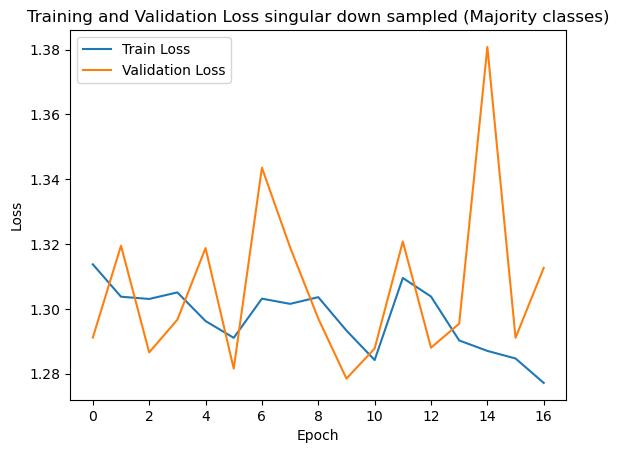

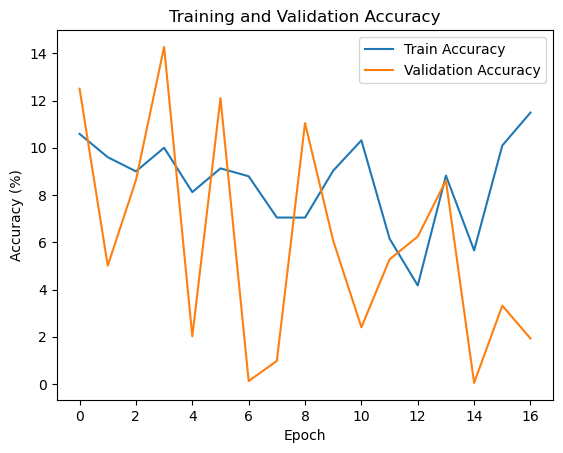

    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    1.313717       10.587276  1.291115     12.498025
1       2    1.303727        9.600326  1.319471      5.008690
2       3    1.303035        9.000816  1.286549      8.626955
3       4    1.305057       10.000000  1.296626     14.267657
4       5    1.296215        8.123980  1.318748      2.022436
5       6    1.291042        9.127243  1.281529     12.103018
6       7    1.303123        8.792822  1.343537      0.126402
7       8    1.301523        7.047308  1.318965      0.979618
8       9    1.303584        7.043230  1.296974     11.044399
9      10    1.293277        9.029364  1.278460      6.067309
10     11    1.284184       10.314029  1.287745      2.401643
11     12    1.309514        6.154160  1.320767      5.277295
12     13    1.303780        4.172104  1.287989      6.241112
13     14    1.290229        8.821370  1.295416      8.611155
14     15    1.287008        5.656607  1.380820      0.047401
15     1

In [50]:
plt.plot(range(num_epochs_runned), train_losses, label="Train Loss")
plt.plot(range(num_epochs_runned), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss singular down sampled (Majority classes)')
plt.show()

# Plot training and validation accuracy
plt.plot(range(num_epochs_runned), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs_runned), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the results in a DataFrame for reporting
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_runned + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies
})

print(results_df)